In [1]:
import json
from PIL import Image
import numpy as np
import cv2
import os

In [2]:
# укажем директории с которыми будем работать
BASE_DIR = os.path.abspath('')
START_IMAGE_DIR = os.path.join(BASE_DIR, 'to_label')
OUTPUT_DIR = os.path.join(BASE_DIR, 'plates_img')

Разберемся в структуре данных

In [3]:
with open('P45.json') as f:
    d = json.load(f)
    data = d['data'] #data is list
    data_0 = data[0] #single car dict
    print(data_0)

{'input': {'image': 'https://dbrain-public.s3.amazonaws.com/project/P45/77a55f65-ee92-4070-851c-bf37ed9f0af2/a50bbc8f-9cb8-49bc-89d7-462258898a0b/161.jpg'}, 'payload': {'aabb': {'license_plate': [[[0.18602540834845735, 0.6778846153846154], [0.26406533575317603, 0.6778846153846154], [0.26406533575317603, 0.7548076923076923], [0.18602540834845735, 0.7548076923076923], [0.18602540834845735, 0.6778846153846154]]]}}}


Поработаетм с единичной записью

In [4]:
# Сохраняем ссылку на изображение
image_url = data_0['input']['image'] # OK
# получим название изображения
image_name = os.path.basename(image_url)
image_name

'161.jpg'

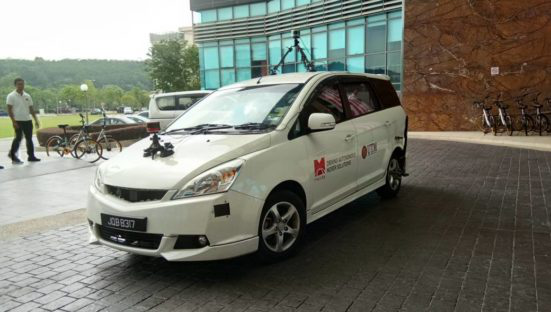

In [5]:
# посмотрим на картинку
car_img_path = os.path.join(START_IMAGE_DIR, image_name)
car_img = Image.open(car_img_path)
car_img

Красиво

In [6]:
bboxes = data_0['payload']['aabb']['license_plate']
bbox = bboxes[0]
print(bbox)

[[0.18602540834845735, 0.6778846153846154], [0.26406533575317603, 0.6778846153846154], [0.26406533575317603, 0.7548076923076923], [0.18602540834845735, 0.7548076923076923], [0.18602540834845735, 0.6778846153846154]]


bbox одного номера представляет из себя словарь из 5 пар значений, которые задают полигон

Судя по всему, библиотека Pillow нас не сможет удолетворить, придется использовать OpenCV

In [7]:
# переведем относительные значения в абсолютные
width, height = car_img.size
new_bboxes = []
for bbox in bboxes:
    new_bbox = []
    for pair in bbox:
        new_pair = []
        new_pair.append(round(pair[0]*width)) #для метотдов OpenCV нужны целые значения
        new_pair.append(round(pair[1]*height))
        new_bbox.append(new_pair)
    new_bboxes.append(new_bbox)
bboxes = new_bboxes
bboxes

[[[102, 212], [146, 212], [146, 236], [102, 236], [102, 212]]]

In [8]:
# нужно преобразование для cv2.boundingRect()
pts = np.array(bboxes[0])
pts

array([[102, 212],
       [146, 212],
       [146, 236],
       [102, 236],
       [102, 212]])

In [9]:
# откроем картинку в OpenCV
img = cv2.imread(car_img_path)

In [10]:
# обрежем номер для одного изображения
for n2, bbox in enumerate(bboxes):
    pts = np.array(bbox)
    ## (1) Crop the bounding rect
    rect = cv2.boundingRect(pts)
    x,y,w,h = rect
    croped = img[y:y+h, x:x+w].copy()

    save_name = '- ' + str(n2) + '.jpg'
    #cv2.imwrite(save_name, croped)

Мы смогли обработать одну запись, теперь возьмемся за все сразу

In [11]:
for entry in data[:]:
    if entry['payload'] is None: # на некоторых изображениях нет номерных знаков
        continue
    if entry['payload'] == {}: # в данных где-то завлялся пустой словарь
        continue
    
    #получаем изображение
    image_url = entry['input']['image']
    image_name = os.path.basename(image_url)
    car_img_path = os.path.join(START_IMAGE_DIR, image_name)
    img = cv2.imread(car_img_path)
    height = np.size(img, 0)
    width = np.size(img, 1)
    
    # подготовим bbox-ы
    bboxes = entry['payload']['aabb']['license_plate']
    #преобразование относительных значений
    new_bboxes = []
    for bbox in bboxes:
        new_bbox = []
        for pair in bbox:
            new_pair = []
            new_pair.append(round(pair[0]*width)) #для метотдов OpenCV нужны целые значения
            new_pair.append(round(pair[1]*height))
            new_bbox.append(new_pair)
        new_bboxes.append(new_bbox)
    bboxes = new_bboxes
    
    # вырезаем все номера с изображения и сохраняем
    for n, bbox in enumerate(bboxes):
        pts = np.array(bbox)
        ## Crop the bounding rect
        rect = cv2.boundingRect(pts)
        x,y,w,h = rect
        croped = img[y:y+h, x:x+w].copy()
        
        #сохраняем в директорию plates_img в виде <номер изображения>-<номер номера>.jpg
        save_name = os.path.join(OUTPUT_DIR, image_name[:-4] + '-' + str(n) + '.jpg')
        cv2.imwrite(save_name, croped)  

Все готово! Результат можно посмотреть в директроии plates_img/